<img src="../assets/ga-logo.png" style="float: left; margin: 20px; height: 55px">

# K-Means Clustering with Seeds Data

---

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') 

import seaborn as sns

### 1. Import the data

In [3]:
seeds = pd.read_csv("seeds.csv")

In [8]:
# A:
seeds.head()

,area,perimeter,compactness,length,width,asymmetry_coeff,groove_length,species
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [10]:
seeds.shape

(210, 8)

In [12]:
seeds['species'].value_counts()

species
1    70
2    70
3    70
Name: count, dtype: int64

### 2. Do some EDA of relationships between features.

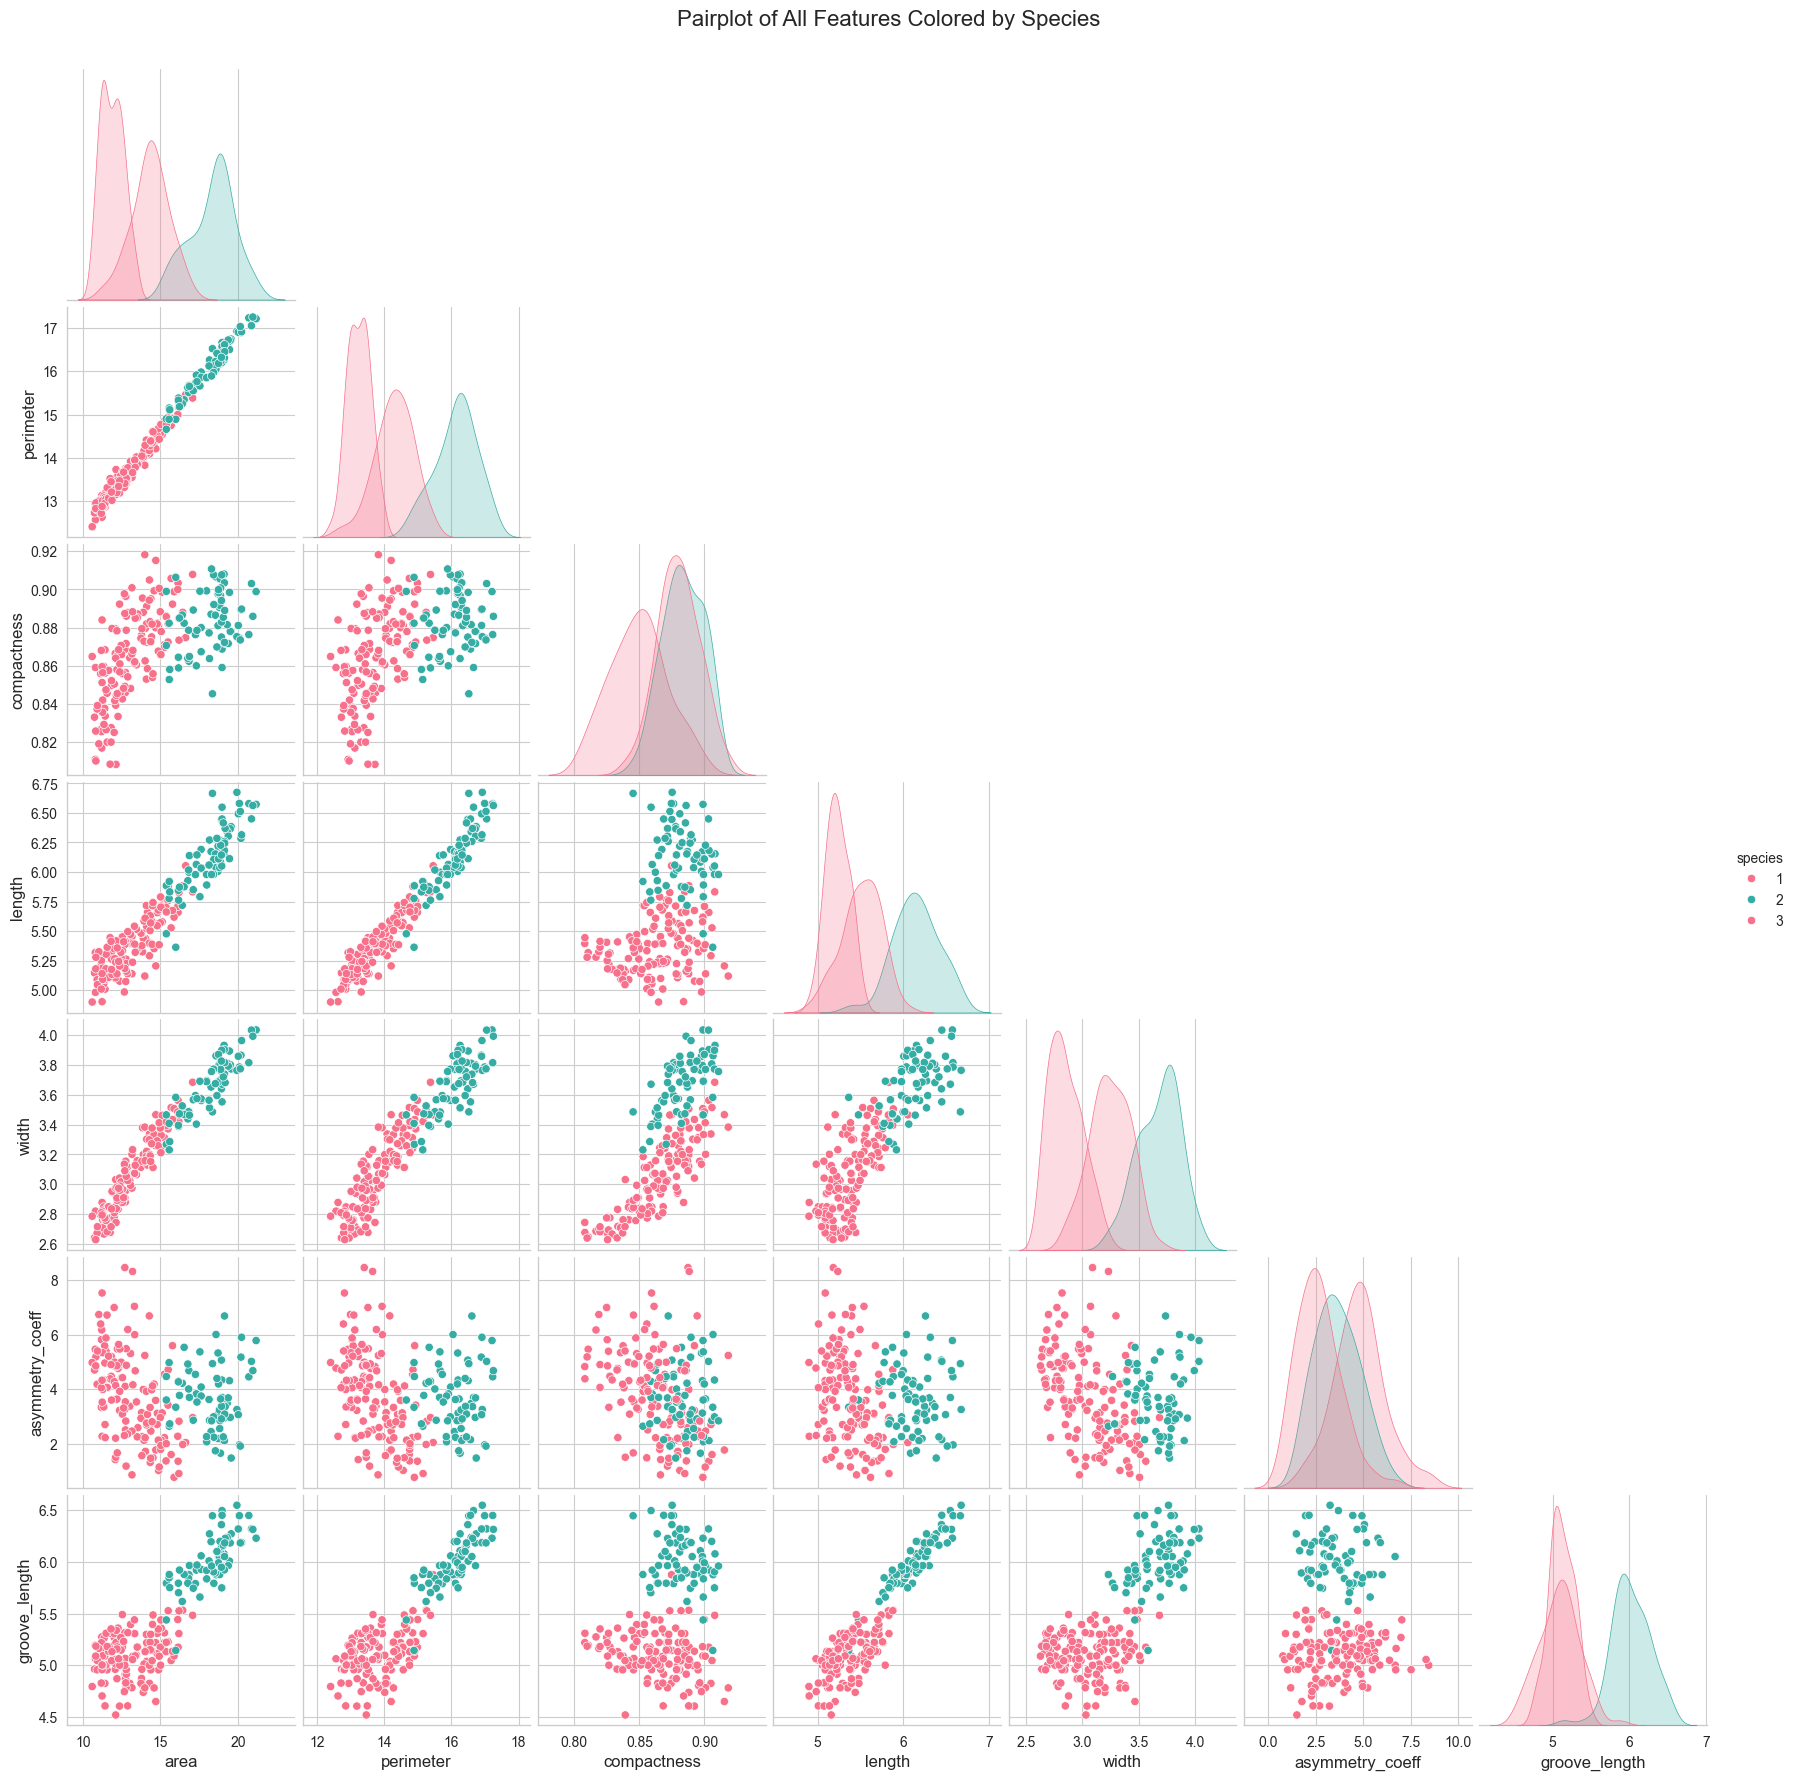

In [14]:
# Plot the Data to see the distributions/relationships
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

sns.pairplot(seeds, hue='species', diag_kind='kde', corner=True, palette='husl')
plt.suptitle("Pairplot of All Features Colored by Species", y=1.02, fontsize=16)
plt.show()


In [17]:
# Check for nulls
seeds.isnull().sum()

area               0
perimeter          0
compactness        0
length             0
width              0
asymmetry_coeff    0
groove_length      0
species            0
dtype: int64

In [21]:
# Look at the real species labels.
print("Unique species labels:", seeds['species'].unique())
print("\nValue counts:")
print(seeds['species'].value_counts().sort_index())

Unique species labels: [1 2 3]

Value counts:
species
1    70
2    70
3    70
Name: count, dtype: int64


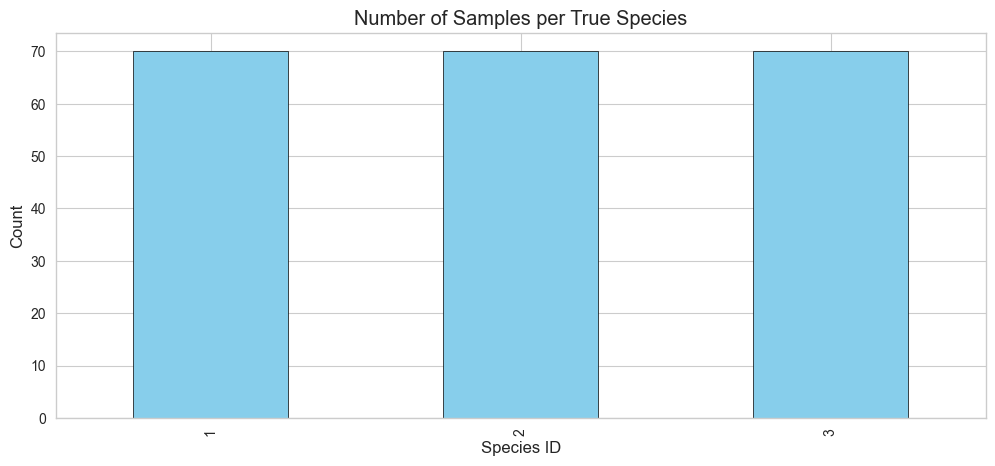

In [22]:
plt.figure(figsize=(12, 5))
seeds['species'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per True Species')
plt.xlabel('Species ID')
plt.ylabel('Count')
plt.show()

Remember, clustering is a unsupervised learning method so known classes will never be a thing.  In this situation we can see that the `perimiter` vs. `groove_length` is a good visualization to view the proper classes class, and we can use later to compare the results of clustering to a true value.

### 3. Prepare the data for clustering

1. Remove the `species` column. We will see if the clusters from K-Means end up like the actual species.
2. Put the features on the same scale.

In [26]:
# 1. Remove species column
X = seeds.drop('species', axis=1)
y = seeds['species'].copy()        # keep for later comparison

# 2. Put features on the same scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

print("Data ready. X_scaled shape:", X_scaled.shape)

Data ready. X_scaled shape: (210, 7)


### 4. Clustering with K-Means

- Cluster the data to our our target groups.
- We know that there are 3 actual classes. However, in an actual situation in which we used clustering we would have no idea. Lets initally try using the default K for `KMeans`(8).

In [27]:
from sklearn.cluster import KMeans

# Cluster with default k=8
km = KMeans(n_clusters=8, random_state=42)
cluster_labels = km.fit_predict(X_scaled)

print("Clustering done with k=8")
print("Cluster labels shape:", cluster_labels.shape)


Clustering done with k=8
Cluster labels shape: (210,)


### 5. Get the labels and centroids for out first clustering model.

In [29]:
# Get the cluster labels
labels = km.labels_

# Get the centroids
centroids = km.cluster_centers_

print("Labels shape:", labels.shape)
print("Centroids shape:", centroids.shape)  # (8, 7)

Labels shape: (210,)
Centroids shape: (8, 7)


### 6. Compute the silouette score and visually examine the results of the 8 clusters. 

_(pairplot with hue)_

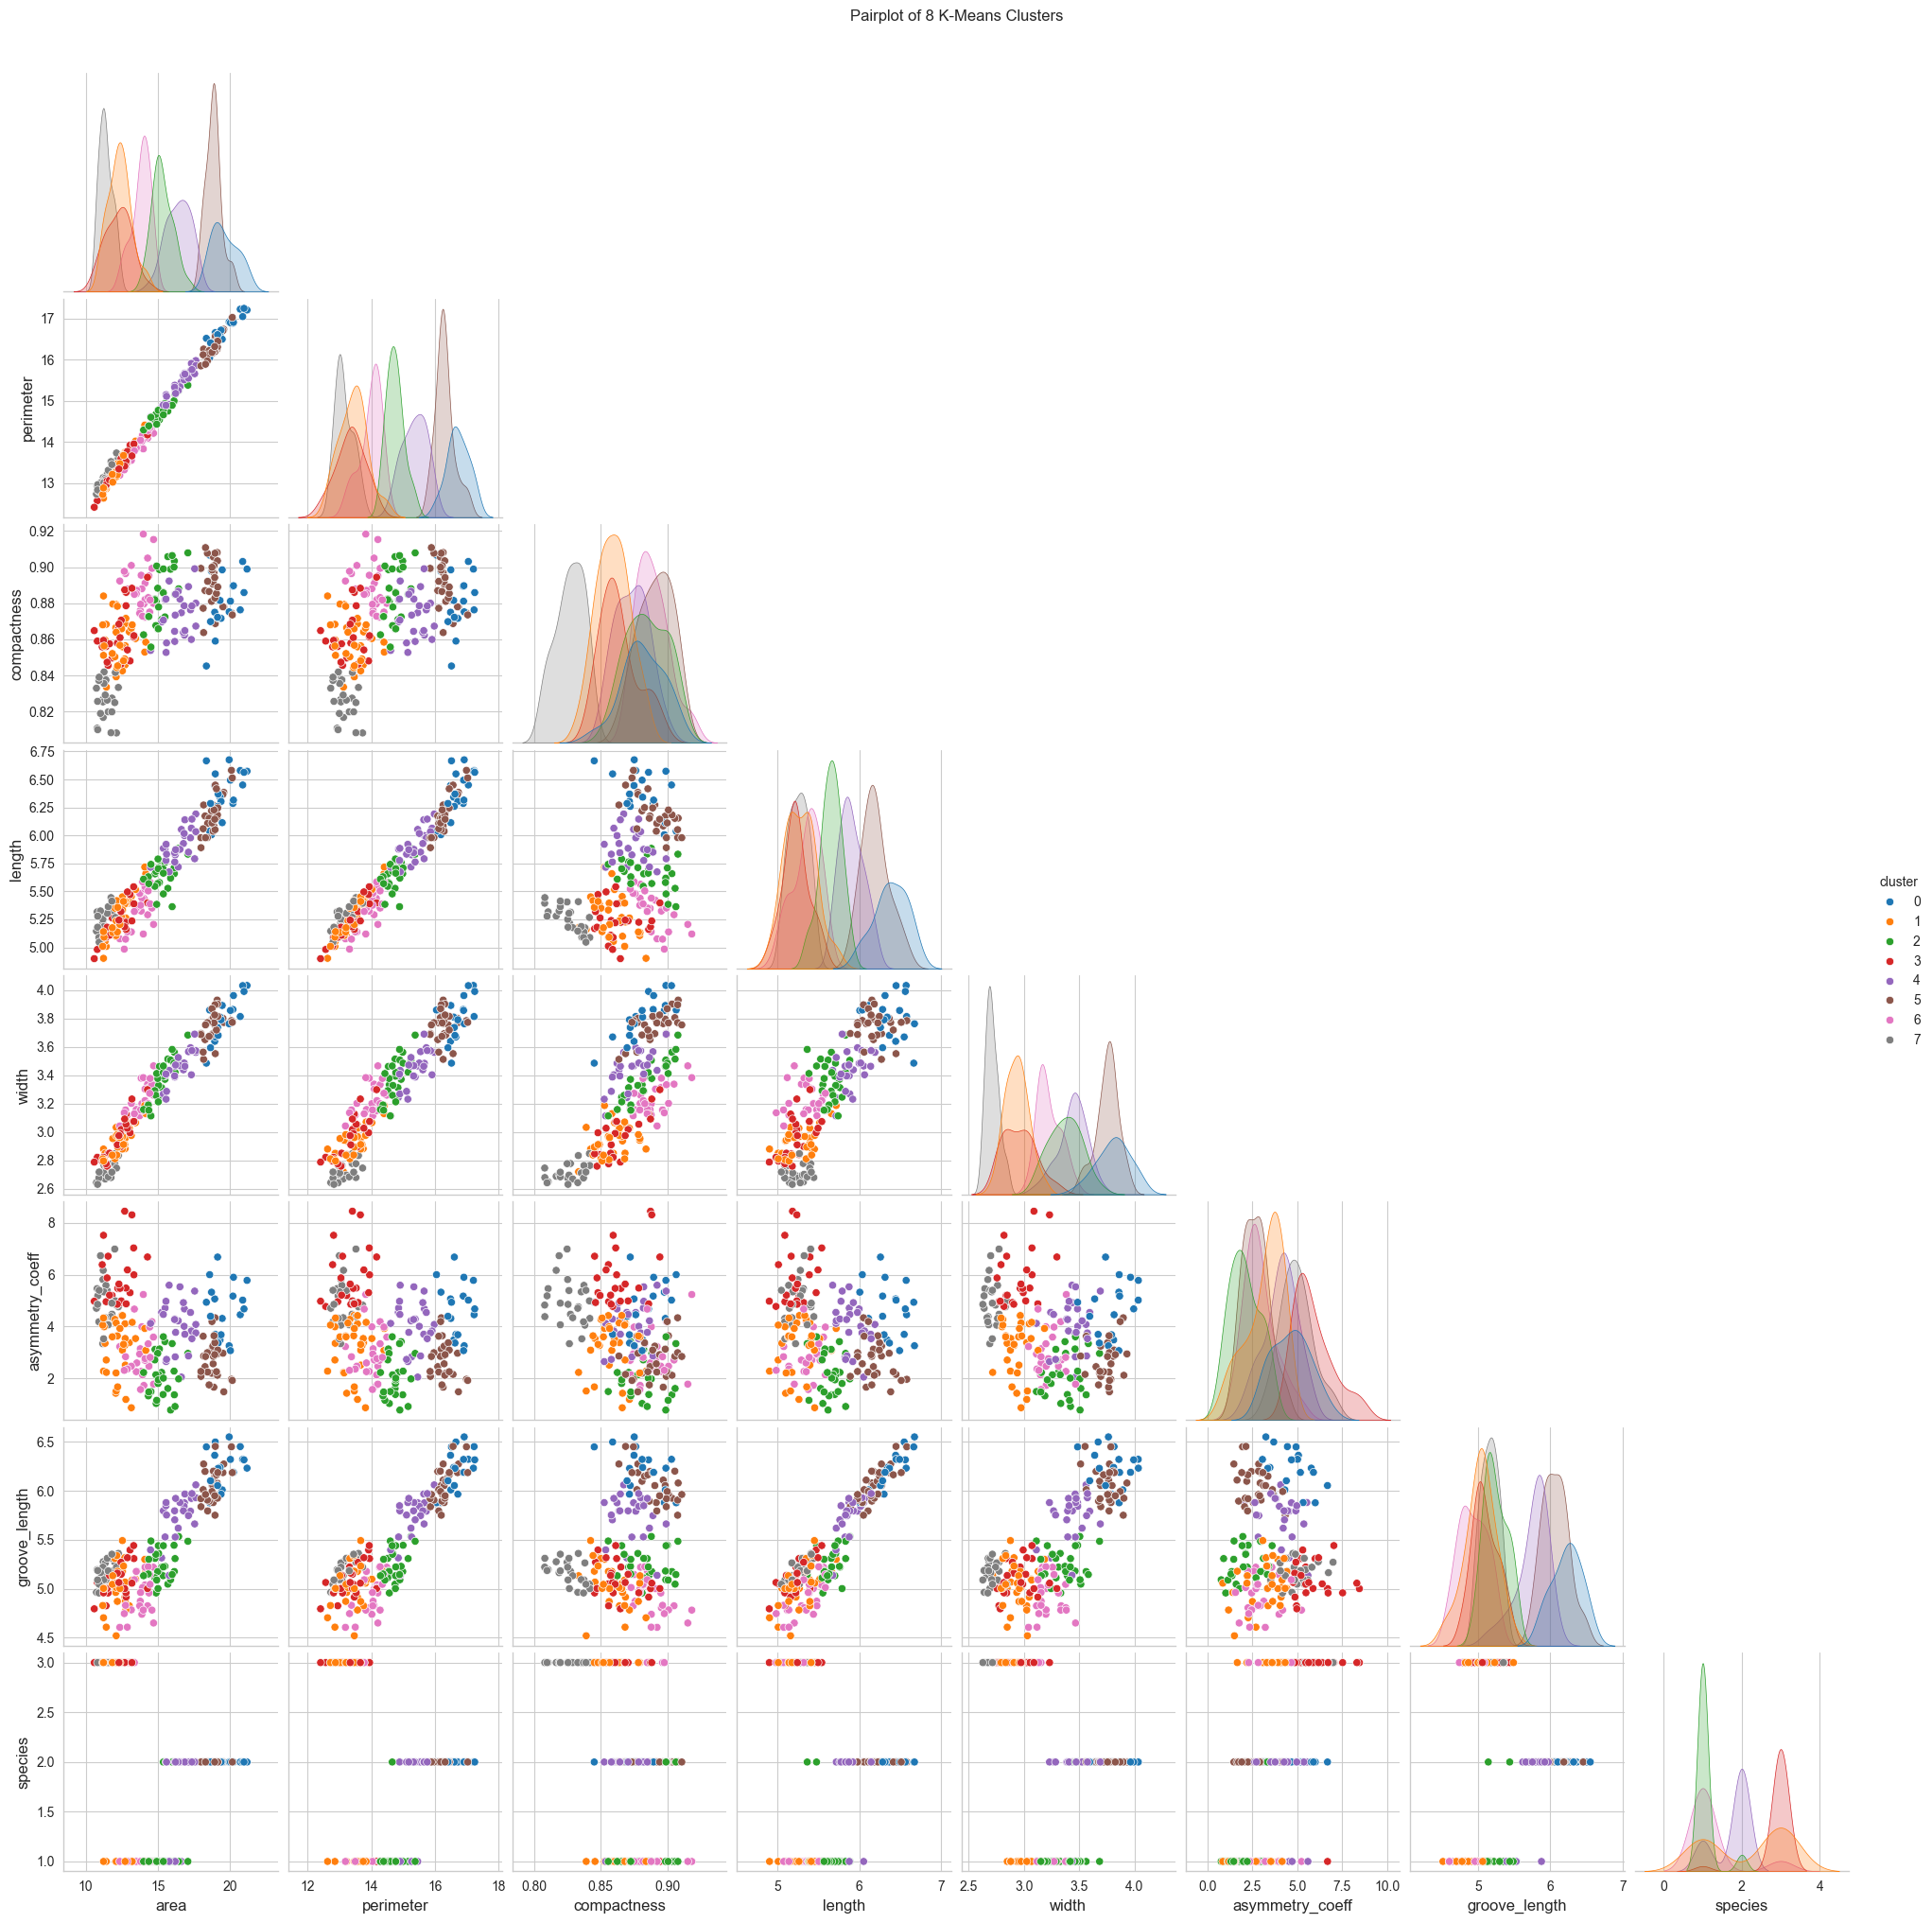

In [30]:
from sklearn.metrics import silhouette_score
import seaborn as sns


# Add cluster labels back to original df for easy plotting
seeds_plot = seeds.copy()
seeds_plot['cluster'] = labels

# Pairplot with cluster hue (diagonal = KDE)
sns.pairplot(seeds_plot, hue='cluster', diag_kind='kde', corner=True, palette='tab10')
plt.suptitle('Pairplot of 8 K-Means Clusters', y=1.02)
plt.show()

### 7. Repeat steps #4 and #6 with two selected or random K values and compare the results to the k=8 model.

k= 3 → Silhouette Score: 0.4024


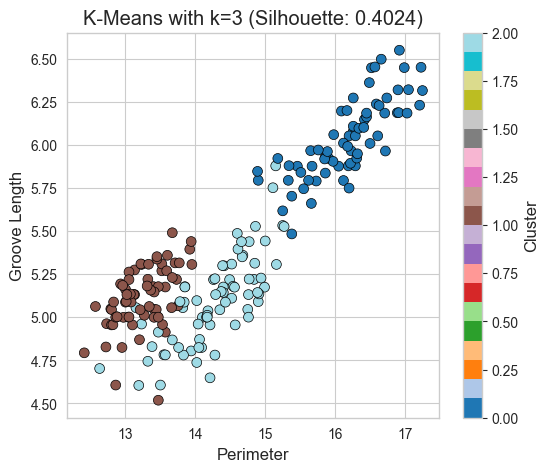

k=36 → Silhouette Score: 0.2338


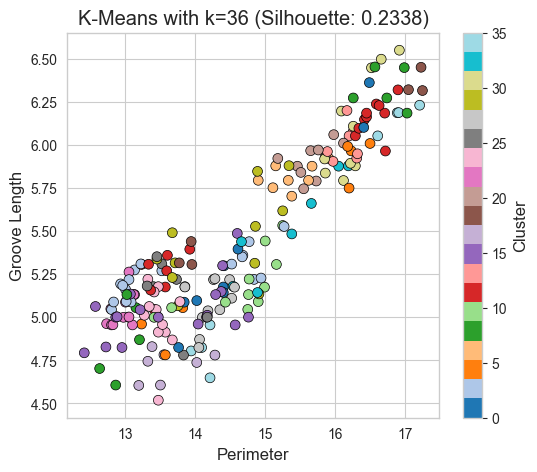

In [31]:
import random

random.randint(1,25), random.randint(1,25)

# Chosen k values
for k in [3, 36]:
    # Fit
    km = KMeans(n_clusters=k, random_state=42)
    labels_k = km.fit_predict(X_scaled)
    
    # Silhouette
    sil = silhouette_score(X_scaled, labels_k)
    print(f"k={k:2d} → Silhouette Score: {sil:.4f}")
    
    # Plot (perimeter vs groove_length)
    plt.figure(figsize=(6,5))
    plt.scatter(X['perimeter'], X['groove_length'], c=labels_k, cmap='tab20', s=50, edgecolors='k')
    plt.title(f'K-Means with k={k} (Silhouette: {sil:.4f})')
    plt.xlabel('Perimeter')
    plt.ylabel('Groove Length')
    plt.colorbar(label='Cluster')
    plt.show()

In [ ]:
# A:

### 8. Build a function to find the optimal number of clusters using silhouette score as the criteria.
1. Function should accept a range and a dataframe as arguments
2. Returns the optimal K value, associate silhoutte and scaling method.
3. Your function should also consider the scaled results of the data. 
    - `normalize`, `StandardScaler`, `MinMaxScaler`


Once you have found the optimal K and version of the data, visualize the clusters.





Best k          : 2
Best scaler     : Normalizer
Silhouette Score: 0.3197


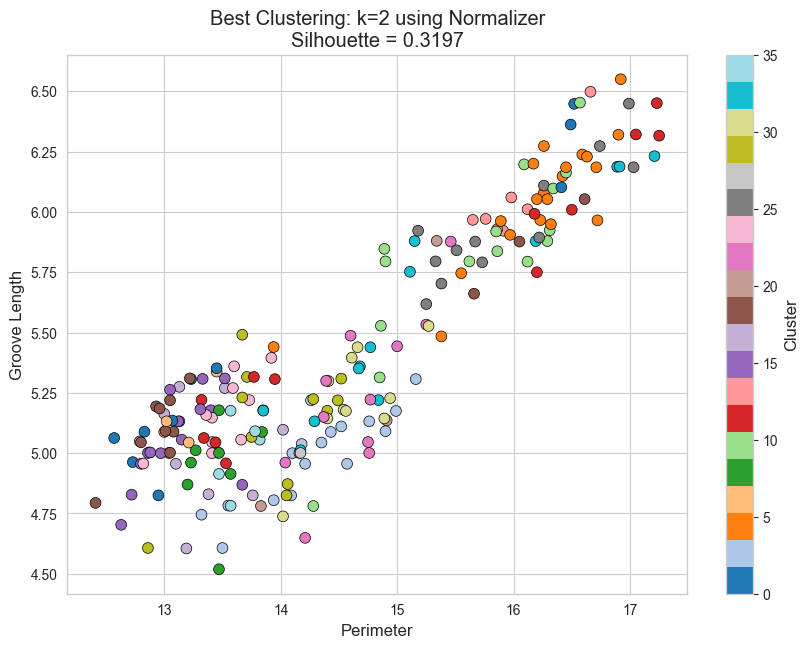

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np

def find_optimal_k_silhouette(seeds_features, k_range=range(2, 50)):
    """
    Finds the best k and best scaling method using silhouette score.
    seeds_features: DataFrame with only numerical features (no species)
    k_range: range of k values to test
    """
    X = seeds_features.values
    sc = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler':   MinMaxScaler(),
        'Normalizer':     Normalizer()
    }
    
    best_score = -1
    best_k = None
    best_sc_name = None
    best_labels = None
    
    for name, sc in sc.items():
        X_scaled = sc.fit_transform(X)
        
        for k in k_range:
            kme = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            
            if score > best_score:
                best_score = score
                best_k = k
                best_scaler_name = name
                best_labels = labels
    
    print(f"Best k          : {best_k}")
    print(f"Best scaler     : {best_scaler_name}")
    print(f"Silhouette Score: {best_score:.4f}")
    
    return best_k, best_scaler_name, best_score, best_labels

# Run our funtion:
optimal_k, scaler_used, score, final_labels = find_optimal_k_silhouette(X)

# Visualize the best result:
plt.figure(figsize=(10, 7))
plt.scatter(X['perimeter'], X['groove_length'], c=final_labels, cmap='tab20', s=60, edgecolors='k')
plt.title(f'Best Clustering: k={optimal_k} using {scaler_used}\nSilhouette = {score:.4f}')
plt.xlabel('Perimeter')
plt.ylabel('Groove Length')
plt.colorbar(label='Cluster')
plt.show()